In [1]:
%load_ext autoreload
%autoreload 2

from aeon.datasets import load_classification

import numpy as np
import pandas as pd
import pickle
import torch
import random
import csv

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import seaborn as sns
from sklearn import metrics
import squarify

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from weights_parser import WeightsParser
from models import LogisticRegressionWithSummariesAndBottleneck_Wrapper
from custom_losses import custom_bce_horseshoe
from preprocess_helpers import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import binary_cross_entropy_with_logits
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from torchmetrics import AUROC

from itertools import combinations

from tqdm import tqdm
from time import sleep
from helper import *
import collections
import optuna
from optuna.trial import TrialState
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_timeline

In [2]:
X, y, meta_data = load_classification("SpokenArabicDigits")
print(" Shape of X = ", len(X), X[0].shape)
print(" Shape of y = ", y.shape)
print(" Meta data = ", meta_data)
y = y.astype(int)
y


 Shape of X =  8798 (13, 38)
 Shape of y =  (8798,)
 Meta data =  {'problemname': 'spokenarabicdigits', 'timestamps': False, 'missing': False, 'univariate': False, 'equallength': False, 'classlabel': True, 'targetlabel': False, 'class_values': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']}


array([ 1,  1,  1, ..., 10, 10, 10])

In [3]:
lengths = []
for i, x in enumerate(X):
    lengths.append(x.shape[1])
lengths.sort()
counter = collections.Counter(lengths)
counter


Counter({4: 1,
         7: 2,
         9: 3,
         11: 1,
         12: 2,
         13: 3,
         14: 6,
         15: 10,
         16: 6,
         17: 8,
         18: 8,
         19: 13,
         20: 13,
         21: 23,
         22: 33,
         23: 57,
         24: 67,
         25: 75,
         26: 102,
         27: 110,
         28: 113,
         29: 164,
         30: 225,
         31: 254,
         32: 297,
         33: 382,
         34: 367,
         35: 378,
         36: 403,
         37: 485,
         38: 444,
         39: 484,
         40: 431,
         41: 388,
         42: 343,
         43: 342,
         44: 353,
         45: 317,
         46: 320,
         47: 260,
         48: 223,
         49: 173,
         50: 196,
         51: 149,
         52: 114,
         53: 93,
         54: 104,
         55: 77,
         56: 82,
         57: 66,
         58: 50,
         59: 44,
         60: 33,
         61: 24,
         62: 17,
         63: 9,
         64: 11,
         65: 3,
 

In [4]:
def preprocess_data_binary(X, y, min_size):
    
    equi_length_X = []
    select_idx = []
    for i, x in enumerate(X):
        if x.shape[1] >= min_size:
            select_idx.append(i)
            equi_length_X.append(x[:, :min_size])

    equi_length_X = np.array(equi_length_X)
    equi_length_X = equi_length_X.swapaxes(1,2)

    indicators_3d = ~np.isnan(equi_length_X)

    data = np.concatenate([equi_length_X, indicators_3d], axis=-1)
    
    ## target
    y = y[select_idx]
    
    # convert problem to 1 vs all
    y[y > 1] = 0
    
    # convert y to logits
    y_logits = np.vstack([(~y.astype(bool)).astype(int), y])
    y_logits = np.swapaxes(y_logits, 0, 1)
    
    # weights
    pos_prop = np.mean(np.array(y)[:, 1])
    p_weight = torch.Tensor([1 / (1 - pos_prop), 1 / pos_prop]).cuda()
    
    return data, y_logits, p_weight

def preprocess_data_multiclass(X, y, min_size):
    
    equi_length_X = []
    select_idx = []
    for i, x in enumerate(X):
        if x.shape[1] >= min_size:
            select_idx.append(i)
            equi_length_X.append(x[:, :min_size])

    equi_length_X = np.array(equi_length_X)
    equi_length_X = equi_length_X.swapaxes(1,2)

    indicators_3d = ~np.isnan(equi_length_X)

    data = np.concatenate([equi_length_X, indicators_3d], axis=-1) # (N x ts_length x 2*changing_dim)
    
    ## target
    y = y[select_idx]
    
    y_unique = np.unique(y)
    num_classes = len(y_unique)
    
    # initiazing datasets
    weights = compute_class_weight(class_weight='balanced', classes=y_unique, y=y)
    weights = torch.Tensor(weights).cuda()
    
    # 1 hot encode
    y_one_hot = np.eye(num_classes)[y-1]
    
    return data, y_one_hot, num_classes, weights

In [19]:
def tensor_wrap(x, klass=torch.Tensor):
    return x if 'torch' in str(type(x)) else klass(x)

def initializeData(r, X, y):   
    
    # train-test-split
    torch.set_printoptions(sci_mode=False)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = r, stratify = y)

    # train-val split
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = r, stratify = y_train)

    X_train_pt = Variable(tensor_wrap(X_train)).cuda()
    y_train_pt = Variable(tensor_wrap(y_train, torch.FloatTensor)).cuda()

    X_val_pt = Variable(tensor_wrap(X_val)).cuda()
    y_val_pt = Variable(tensor_wrap(y_val, torch.FloatTensor)).cuda()

    X_test_pt = Variable(tensor_wrap(X_test)).cuda()
    y_test_pt = Variable(tensor_wrap(y_test, torch.FloatTensor)).cuda()

    batch_size = 128

    train_dataset = TensorDataset(X_train_pt, y_train_pt)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    val_dataset = TensorDataset(X_val_pt, y_val_pt)
    val_loader = DataLoader(val_dataset, batch_size = X_val_pt.shape[0], shuffle=True, num_workers=0)

    # test_dataset = TensorDataset(X_test_pt, y_test_pt)
    # test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    return train_loader, val_loader, X_test_pt, y_test_pt


In [6]:
# Initialize all cutoffs to x
def init_cutoffs_to_twelve(d):
    return np.zeros(d) + 12

def init_cutoffs_to_zero(d):
    return np.zeros(d)

def init_cutoffs_to_twentyfour(d):
    return np.zeros(d) + 24

def init_cutoffs_to_x(d, x):
    return np.zeros(d) + x

# Initialize all cutoffs to a uniform random integer between 0 and (x - 1)
def init_cutoffs_randomly(d):
    return np.random.randint(6, size=d).astype('float')

In [7]:
# init the upper and lower thresholds to random values
def init_rand_upper_thresholds(d):
    return np.random.rand(d)

def init_rand_lower_thresholds(d):
    return np.random.rand(d) - 1

def init_zeros(d):
    return np.zeros(d)

In [8]:
def initializeModel(c, input_dim, changing_dim, time_len, n_classes = 2):
    logregbottleneck = LogisticRegressionWithSummariesAndBottleneck_Wrapper(input_dim, 
                                                changing_dim, 
                                                9,                     
                                                c,
                                                True,
                                                init_cutoffs_to_zero, 
                                                init_rand_lower_thresholds, 
                                                init_rand_upper_thresholds,
                                                cutoff_times_temperature=0.1,
                                                cutoff_times_init_values=None,
                                                time_len=time_len,
                                                opt_lr = 2e-4,
                                                opt_weight_decay = 2e-05,
                                                l1_lambda=0.001,
                                                cos_sim_lambda=0.01,
                                                n_classes = n_classes
                                                )
    logregbottleneck.cuda()
    return logregbottleneck

In [9]:
def set_seed(r):
    torch.backends.cudnn.deterministic = True
    random.seed(r)
    torch.manual_seed(r)
    torch.cuda.manual_seed(r)
    np.random.seed(r)

In [17]:
def objective_binary(ts_length, num_concept):
    # TS_LENGTH = trial.suggest_int("ts_length", 4, 4)
    # NUM_CONCEPT = trial.suggest_int("num concept", 1, 10)
    model_path = "./models/arabic/binary/arabic_length_{}_c{}.pt"

    data, y_logits, weights = preprocess_data_binary(X, y, ts_length)
    input_dim = data.shape[2]
    changing_dim = X[0].shape[0]
    train_loader, val_loader, X_test, y_test = initializeData(1, data, y_logits)
    model = initializeModel(num_concept, input_dim, changing_dim, ts_length)
    
    train_loss, val_loss = model.fit(train_loader, val_loader, weights, model_path.format(ts_length, num_concept), 1000)
    
    preds = model(tensor_wrap(X_test))
    
    auroc = AUROC(task="binary")
    auc = auroc(preds, y_test).item()
    
    return val_loss, auc

def objective_multi_class(ts_length, num_concept):
    # TS_LENGTH = trial.suggest_int("ts_length", 4, 4)
    # NUM_CONCEPT = trial.suggest_int("num concept", 1, 10)
    model_path = "./models/arabic/multiclass/arabic_length_{}_c{}.pt"

    data, y_ohe, num_classes, weights = preprocess_data_multiclass(X, y, ts_length)
    input_dim = data.shape[2]
    changing_dim = X[0].shape[0]
    train_loader, val_loader, X_test, y_test = initializeData(1, data, y_ohe)
    model = initializeModel(num_concept, input_dim, changing_dim, ts_length, num_classes)
    
    train_loss, val_loss = model.fit(train_loader, val_loader, weights, model_path.format(ts_length, num_concept), 1000)
    
    probs = model.forward_probabilities(X_test)
    
    auroc = AUROC(task="multiclass", num_classes=num_classes)
    auc = auroc(probs, torch.argmax(y_test, dim=1)).item()
    
    return val_loss, auc


In [11]:
history = []
ts_length = 4
for c in range(1,22):
    print(ts_length, c)
    val_loss, auc = objective_binary(ts_length, c)
    history.append(np.array([ts_length, c, val_loss, auc]))
history = np.array(history)
history.shape


4 1
Loaded model from ./models/arabic_length_4_c1.pt


0it [00:00, ?it/s]


4 2
Loaded model from ./models/arabic_length_4_c2.pt


0it [00:00, ?it/s]


4 3
Loaded model from ./models/arabic_length_4_c3.pt


0it [00:00, ?it/s]


4 4
Loaded model from ./models/arabic_length_4_c4.pt


0it [00:00, ?it/s]


4 5
Loaded model from ./models/arabic_length_4_c5.pt


0it [00:00, ?it/s]


4 6
Loaded model from ./models/arabic_length_4_c6.pt


0it [00:00, ?it/s]


4 7
Loaded model from ./models/arabic_length_4_c7.pt


0it [00:00, ?it/s]


4 8
Loaded model from ./models/arabic_length_4_c8.pt


0it [00:00, ?it/s]


4 9
Loaded model from ./models/arabic_length_4_c9.pt


0it [00:00, ?it/s]


4 10
Loaded model from ./models/arabic_length_4_c10.pt


0it [00:00, ?it/s]


4 11
Loaded model from ./models/arabic_length_4_c11.pt


0it [00:00, ?it/s]


4 12
Loaded model from ./models/arabic_length_4_c12.pt


0it [00:00, ?it/s]


4 13
Loaded model from ./models/arabic_length_4_c13.pt


100%|██████████| 100/100 [03:04<00:00,  1.84s/it]


4 14
Loaded model from ./models/arabic_length_4_c14.pt


0it [00:00, ?it/s]


4 15
Loaded model from ./models/arabic_length_4_c15.pt


100%|██████████| 200/200 [07:44<00:00,  2.32s/it]


4 16
Loaded model from ./models/arabic_length_4_c16.pt


0it [00:00, ?it/s]


4 17
Loaded model from ./models/arabic_length_4_c17.pt


0it [00:00, ?it/s]


4 18
Loaded model from ./models/arabic_length_4_c18.pt


0it [00:00, ?it/s]


4 19
Loaded model from ./models/arabic_length_4_c19.pt


0it [00:00, ?it/s]


4 20
Loaded model from ./models/arabic_length_4_c20.pt


0it [00:00, ?it/s]


4 21


100%|██████████| 1000/1000 [1:07:29<00:00,  4.05s/it]


(21, 4)

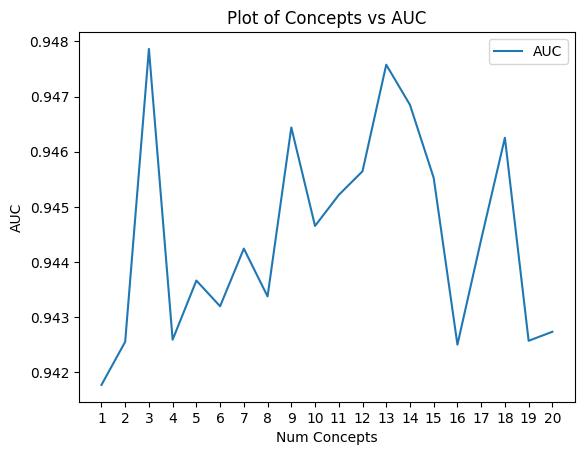

In [15]:
# plot
plt.plot(history[:, 1], history[:, 3], label='AUC')

plt.xlabel('Num Concepts')
plt.ylabel('AUC')
plt.title('Plot of Concepts vs AUC')
plt.xticks(np.arange(min(history[:, 1]), max(history[:, 1])+1, 1))

plt.legend()
plt.show()


In [13]:
c = 3

history2 = []
for ts_length in range(4,21,2):
    print(ts_length, c)
    val_loss, auc = objective_binary(ts_length, c)
    history2.append(np.array([ts_length, c, val_loss, auc]))
history2 = np.array(history2)
history2.shape


4 3
Loaded model from ./models/arabic_length_4_c3.pt


0it [00:00, ?it/s]


6 3


100%|██████████| 1000/1000 [07:35<00:00,  2.19it/s]


8 3


100%|██████████| 1000/1000 [07:35<00:00,  2.20it/s]


10 3


100%|██████████| 1000/1000 [07:35<00:00,  2.19it/s]


12 3


100%|██████████| 1000/1000 [07:35<00:00,  2.20it/s]


14 3


100%|██████████| 1000/1000 [07:34<00:00,  2.20it/s]


16 3


100%|██████████| 1000/1000 [07:36<00:00,  2.19it/s]


18 3


100%|██████████| 1000/1000 [07:37<00:00,  2.18it/s]


20 3


100%|██████████| 1000/1000 [07:35<00:00,  2.20it/s]


(9, 4)

In [ ]:
# plot
plt.plot(history2[:, 0], history2[:, 3], label='AUC')

plt.xlabel('TS Length')
plt.ylabel('AUC')
plt.title('Plot of TS Length vs AUC')

plt.legend()
plt.show()


## Multi-class

In [18]:
history = []
ts_length = 4
for c in range(1,5):
    print(ts_length, c)
    val_loss, auc = objective_multi_class(ts_length, c)
    history.append(np.array([ts_length, c, val_loss, auc]))
history = np.array(history)
history.shape


4 1
Loaded model from ./models/arabic/multiclass/arabic_length_4_c1.pt


0it [00:00, ?it/s]


10
torch.Size([1320, 10])
torch.Size([1320, 10])
4 2


100%|██████████| 1000/1000 [06:52<00:00,  2.42it/s]


10
torch.Size([1320, 10])
torch.Size([1320, 10])
4 3


100%|██████████| 1000/1000 [06:53<00:00,  2.42it/s]


10
torch.Size([1320, 10])
torch.Size([1320, 10])
4 4


100%|██████████| 1000/1000 [06:53<00:00,  2.42it/s]

10
torch.Size([1320, 10])
torch.Size([1320, 10])


(4, 4)

In [ ]:
# plot
plt.plot(history[:, 1], history[:, 3], label='AUC')
plt.plot(history[:, 1], history[:, 2], label='Val Loss')

plt.xlabel('Num Concepts')
plt.ylabel('AUC')
plt.title('Plot of Concepts vs AUC')
plt.xticks(np.arange(min(history[:, 1]), max(history[:, 1])+1, 1))

plt.legend()
plt.show()
